### Imports

In [1]:
import gc
import os
from typing import List

import numpy as np
import seaborn as sns
import pandas as pd
import torch
import umap
from PIL import Image
from sklearn.manifold import TSNE
from torch.nn.functional import cosine_similarity
from torchview import draw_graph
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPModel
from scipy.spatial.distance import cosine, euclidean

import wandb
from plotly_tools import *

os.environ["HF_HOME"] = "../.hf_home"
random_seed = 42
torch.manual_seed(random_seed)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

### Load CLIP Model

In [2]:
model_vision = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir=os.environ['HF_HOME'])
model_text = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir=os.environ['HF_HOME'])
model_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir=os.environ['HF_HOME'])
model_image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir=os.environ['HF_HOME'])

clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336", cache_dir=os.environ['HF_HOME'])
vis_proj = clip.visual_projection
text_proj = clip.text_projection

_ = model_vision.eval()
_ = model_text.eval()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

### Model Visualization

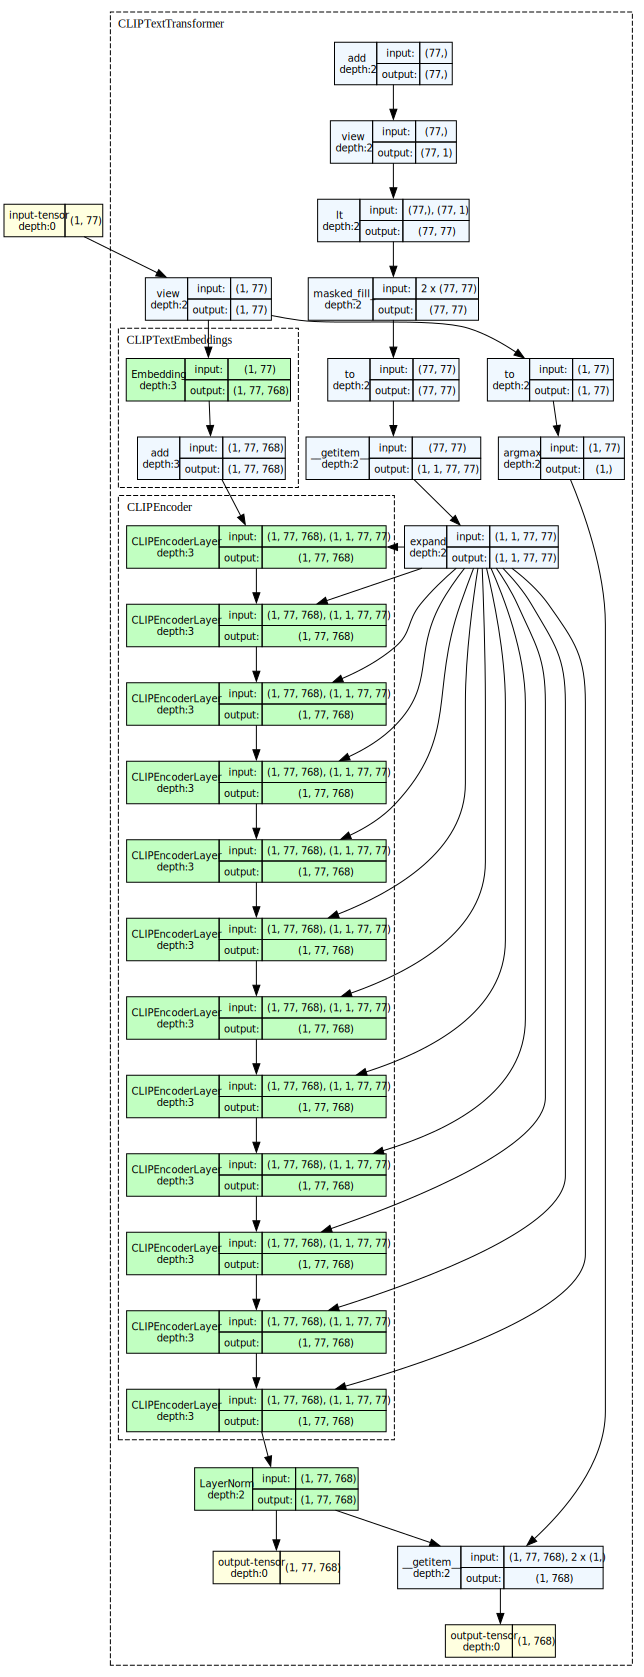

In [3]:
model_graph = draw_graph(model_text, input_size=(1, 77), expand_nested=True, dtypes=[torch.long], device='cpu')
model_graph.visual_graph

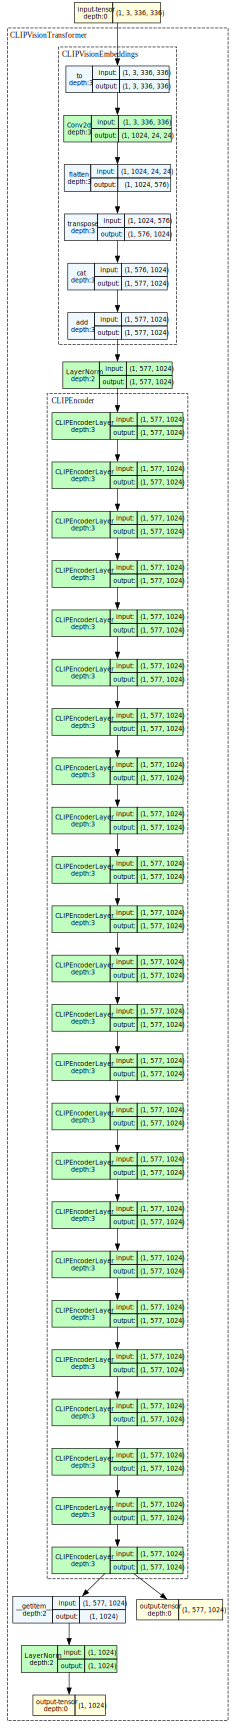

In [4]:
model_graph = draw_graph(model_vision, input_size=(1, 3, 336, 336), expand_nested=True, dtypes=[torch.float], device='cpu')
model_graph.visual_graph

### Sample Data Encoding (Embedding Dimensions)

#### Text Encoder

In [5]:
with torch.no_grad():
    tokenized = model_tokenizer.tokenize("a photo of a cat")
tokenized

['a</w>', 'photo</w>', 'of</w>', 'a</w>', 'cat</w>']

In [6]:
with torch.no_grad():
    tokenized = model_tokenizer.encode("a photo of a cat", return_tensors="pt", padding=True)[0]
    eot_token_pos = len(tokenized) - 1
tokenized

tensor([49406,   320,  1125,   539,   320,  2368, 49407])

In [7]:
with torch.no_grad():
    encoded = model_text(tokenized.unsqueeze(0)).last_hidden_state[0]
    encoded_text = encoded[eot_token_pos]
print(encoded_text.shape)
encoded_text

torch.Size([768])


tensor([-1.2575e+00, -4.6340e-01,  5.6488e-01,  9.1062e-01, -2.9075e+00,
         7.4554e-02, -9.0490e-01, -1.3073e+00, -5.2779e-01,  1.6212e-01,
        -1.6492e+00,  6.7645e-01, -1.3997e+00, -1.1720e+00,  9.5254e-01,
         2.2967e-01, -2.1202e+00,  1.0801e+00,  1.4738e+00,  2.6638e+00,
         3.0293e-01,  1.5535e+00, -1.5637e+00,  7.5946e-01, -6.6199e-01,
        -2.4227e+00, -1.4322e-02, -2.2255e+00,  1.0710e+00, -5.2027e-01,
         6.3751e-01,  6.0827e-01, -6.2860e-02, -3.6243e-01, -8.5936e-02,
         9.1054e-02, -1.4383e+00, -1.5234e+00, -9.5572e-01, -1.4999e-01,
         8.6156e-02,  6.9137e-02, -1.8059e-01, -1.2353e+00,  1.1908e-01,
        -6.6687e-01, -1.0591e+00, -1.9397e-01,  1.1204e+00, -1.0145e+00,
         1.6623e+00, -6.2381e-01, -7.4528e-01,  7.8853e-01, -8.6801e-01,
        -1.5035e+00,  1.6786e+00, -1.1982e+00,  1.2069e+00, -6.8771e-01,
        -1.3149e-01,  2.5230e-01, -5.7269e-01,  8.5608e-01, -1.8933e-01,
         1.0245e+00, -3.9973e-01,  6.8597e-01, -1.9

#### Image Encoder

In [8]:
cat = Image.open("sample_images/cat.jpg").convert("RGB")
image = model_image_processor(images=cat, return_tensors="pt")
print(image['pixel_values'].shape)
image['pixel_values'][0,0]

torch.Size([1, 3, 336, 336])


tensor([[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
        [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
        [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
        ...,
        [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
        [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
        [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]])

In [9]:
with torch.no_grad():
    encoded_image = model_vision(image['pixel_values']).pooler_output[0]
print(encoded_image.shape)
encoded_image

torch.Size([1024])


tensor([ 0.1831,  0.5916,  0.6385,  ..., -1.1224, -0.2709,  0.7680])

#### Projection Layers

In [10]:
proj_image = vis_proj(encoded_image)
proj_text = text_proj(encoded_text)
proj_image.shape, proj_text.shape

(torch.Size([768]), torch.Size([768]))

### Model Inference and Data Preparation for Visualization

In [11]:
run_inference = not os.path.exists("clip_image_text_embeddings.parquet")
print(f"{'' if run_inference else 'not'} running inference")

not running inference


#### Helper Functions

In [12]:
def encode_images(images: List[Image.Image], batch_size=16, output_device="mps") -> torch.Tensor:
    all_embeddings = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        processed = model_image_processor(images=batch, return_tensors="pt").to(device)
        with torch.no_grad():
            model_vision.to(device)
            vis_proj.to(device)
            encoded = model_vision(processed['pixel_values'])
            pooled = encoded.pooler_output
            projected = vis_proj(pooled)
        all_embeddings.append(projected.cpu())

    del processed, encoded, pooled, projected
    torch.mps.empty_cache()
    gc.collect()

    return torch.cat(all_embeddings, dim=0).to(output_device)

def encode_text(text: str, output_device="mps") -> torch.Tensor:
    model_text.eval()
    with torch.no_grad():
        model_text.to(device)
        text_proj.to(device)
        inputs = model_tokenizer(text, return_tensors='pt', padding="max_length", truncation=True).to(device)
        encoded = model_text(**inputs)
        last_hidden_state = encoded.last_hidden_state
        eot_token_pos = inputs['input_ids'].argmax(dim=-1)
        pooled = last_hidden_state[torch.arange(last_hidden_state.shape[0]), eot_token_pos]
        projected = text_proj(pooled)

    del inputs, encoded, last_hidden_state, pooled
    gc.collect()

    return projected.to(output_device)

In [13]:
def to_bytes(img: "Image.Image") -> bytes:
    buf = BytesIO()
    img.save(buf, format="PNG")
    return buf.getvalue()

def from_bytes(byte_im: bytes) -> "Image.Image":
    buf = BytesIO(byte_im)
    img = Image.open(buf)            # formats=("PNG",) optional
    img.load()                       # force read to avoid lazy I/O issues
    return img.convert("RGB")

#### Load Sample Images

In [14]:
if run_inference:
    data_folder = "./sample_images"
    data = {}
    for label in os.listdir(data_folder):
        if os.path.isdir(os.path.join(data_folder, label)):
            data[label] = []
            for file in os.listdir(os.path.join(data_folder, label)):
                if 'urls.txt' not in file:
                    data[label].append(os.path.join(data_folder, label, file))

    data_imgs = {}
    for label in data:
        data_imgs[label] = []
        for img in data[label]:
            try:
                image = Image.open(img).convert("RGB")
                if image.size[0] < 100:
                    del image
                    continue
                data_imgs[label].append(image)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

#### Run Inference (Encode Images and Text)

In [15]:
if run_inference:
    encoded = {}
    for label, imgs in data_imgs.items():
        print(f"Encoding {len(imgs)} images for label {label}")
        encoded_images = encode_images(imgs, output_device="cpu")
        encoded_label = encode_text(label, output_device="cpu")
        encoded[label] = {
            "images": [{
                "image": img,
                "embedding": emb
            } for img, emb in zip(imgs, encoded_images)],
            "text_embedding": encoded_label.squeeze()
        }
        del encoded_images
        del encoded_label
        gc.collect()

#### Save/Load Data

In [16]:
if run_inference:
    dfs = []
    for label in encoded:
        text_emb = encoded[label]["text_embedding"].numpy()
        imgs, embs = zip(*[(item["image"], item["embedding"].numpy()) for item in encoded[label]["images"]])
        df = pd.DataFrame({
            "label": label,
            "image": imgs,
            "image_embedding": embs,
            "text_embedding": [text_emb] * len(imgs)
        })
        dfs.append(df)

    df_concat = pd.concat(dfs, ignore_index=True)
    df_concat['image'] = df_concat['image'].apply(lambda x: to_bytes(x))
    df_concat.to_parquet("clip_image_text_embeddings.parquet", engine='pyarrow', index=False)
else:
    df_concat = pd.read_parquet("clip_image_text_embeddings.parquet", engine='fastparquet')

#### Prepare Data for Visualization

In [18]:
df_img = df_concat.drop(columns=["text_embedding"]).rename(columns={"image_embedding": "target"})
df_img['orig_img'] = df_img['image'].apply(lambda x: from_bytes(x))
df_img['image'] = df_img['image'].apply(lambda x: wandb.Image(from_bytes(x)))

df_txt = df_concat.drop(columns=["image", "image_embedding"]).rename(columns={"text_embedding": "target"}).drop_duplicates(subset="label")

### Data Visualization

#### WandB Logging

In [ ]:
with wandb.init(project="clip-embeddings") as run:
    run.log({"image_embeddings": wandb.Table(dataframe=df_img), "text_embeddings": wandb.Table(dataframe=df_txt)})

In [23]:
df_txt

,label,target
0,a snowy landscape,"[-0.15833393, 0.38590503, 0.40940478, 0.841158..."
147,a plate of food,"[-0.31545588, -0.09217691, 0.514594, -0.369594..."
264,a mouse,"[0.66219544, -0.1156949, 0.8811606, 0.31332073..."
433,a cup of coffee,"[0.6900387, -0.5980805, 0.41566566, -0.3034317..."
638,a starry night,"[0.065533236, -0.42748713, 0.07740402, 0.42080..."
697,a table,"[-0.12026805, -0.010464422, 0.4610654, -0.7069..."
885,a truck,"[0.06994942, -0.25993684, 0.39954418, -0.15555..."
1008,a photo of a dog,"[0.20575847, -0.0479409, 0.35869712, -0.422576..."
1178,a rainbow,"[0.18730842, -0.037098534, 0.68303806, 0.40066..."
1314,a flower,"[0.80751306, -0.098642215, 0.5488185, 0.389719..."


In [27]:
# compute embedding vector length
df_txt['target_norm'] = df_txt['target'].apply(lambda x: np.array(x) / np.linalg.norm(np.array(x)))
df_img['target_norm'] = df_img['target'].apply(lambda x: np.array(x) / np.linalg.norm(np.array(x)))

In [31]:
np.linalg.norm(df_txt['target'][0])

np.float32(15.448172)

#### t-SNE Visualization

In [28]:
tnse = TSNE(n_components=3, random_state=random_seed, init='random', learning_rate='auto', perplexity=5)
results = tnse.fit_transform(np.array(df_img["target_norm"].tolist() + df_txt["target_norm"].tolist()))

img_proj = results[:len(df_img)]
txt_proj = results[len(df_img):]

In [29]:
df_img['tnse-3d'] = img_proj.tolist()
df_img['tnse-3d-0'] = img_proj[:,0]
df_img['tnse-3d-1'] = img_proj[:,1]
df_img['tnse-3d-2'] = img_proj[:,2]

df_txt['tnse-3d'] = txt_proj.tolist()
df_txt['tnse-3d-0'] = txt_proj[:,0]
df_txt['tnse-3d-1'] = txt_proj[:,1]
df_txt['tnse-3d-2'] = txt_proj[:,2]

In [30]:
save_3d_hover_images_html(
    "clip_embeddings_tsne.html",
    img_proj,
    txt_proj,
    df_img['orig_img'].tolist(),
    df_img['label'].tolist(),
    df_txt['label'].tolist(),
)

#### UMAP Visualization

In [32]:
umap = umap.UMAP(n_components=3)
results = umap.fit_transform(np.array(df_img["target"].tolist() + df_txt["target"].tolist()))

img_proj = results[:len(df_img)]
txt_proj = results[len(df_img):]

In [33]:
df_img['umap-3d'] = img_proj.tolist()
df_img['umap-3d-0'] = img_proj[:,0]
df_img['umap-3d-1'] = img_proj[:,1]
df_img['umap-3d-2'] = img_proj[:,2]

df_txt['umap-3d'] = txt_proj.tolist()
df_txt['umap-3d-0'] = txt_proj[:,0]
df_txt['umap-3d-1'] = txt_proj[:,1]
df_txt['umap-3d-2'] = txt_proj[:,2]

In [34]:
save_3d_hover_images_html(
    "clip_embeddings_umap.html",
    img_proj,
    txt_proj,
    df_img['orig_img'].tolist(),
    df_img['label'].tolist(),
    df_txt['label'].tolist(),
)

### Embedding Similarity Visualization

In [39]:
df_txt['target']

0       [-0.15833393, 0.38590503, 0.40940478, 0.841158...
147     [-0.31545588, -0.09217691, 0.514594, -0.369594...
264     [0.66219544, -0.1156949, 0.8811606, 0.31332073...
433     [0.6900387, -0.5980805, 0.41566566, -0.3034317...
638     [0.065533236, -0.42748713, 0.07740402, 0.42080...
697     [-0.12026805, -0.010464422, 0.4610654, -0.7069...
885     [0.06994942, -0.25993684, 0.39954418, -0.15555...
1008    [0.20575847, -0.0479409, 0.35869712, -0.422576...
1178    [0.18730842, -0.037098534, 0.68303806, 0.40066...
1314    [0.80751306, -0.098642215, 0.5488185, 0.389719...
1424    [0.08537117, 0.19656476, 0.6793746, 0.00763675...
1491    [-0.45220092, 0.038227167, 0.31334552, 0.05224...
1641    [-0.3518588, 0.43747127, 0.47682264, -0.917770...
1771    [0.3245458, 0.35539255, 0.104406096, -0.312321...
1896    [-0.002490446, 0.06951463, 0.49461225, -0.2365...
2082    [-0.23109567, 0.7224524, 0.21210627, -0.465667...
2309    [-0.18088615, -0.032188192, 0.34665567, 0.0860...
2459    [0.031

In [40]:
df_img['target']

0       [0.67131895, 0.97655123, 0.5922654, 0.7258275,...
1       [0.2615193, 0.23746951, -0.32714334, 0.6066298...
2       [0.30222332, -0.20398201, 0.273232, 0.44609725...
3       [0.35512078, 0.020768277, 0.42826092, 0.329328...
4       [0.74530965, 1.7560766, 0.32505628, 1.1087168,...
                              ...                        
4998    [0.48863167, 0.23772158, 0.54818326, -0.110137...
4999    [0.6535279, -0.34730875, 1.0882181, -0.4713221...
5000    [1.1660762, 0.55700284, 0.7525938, -0.23318288...
5001    [0.300929, 0.028991006, 0.81037265, 0.41856155...
5002    [0.811282, 0.28038785, 0.5249701, -0.42117304,...
Name: target, Length: 5003, dtype: object

In [42]:
text_embeddings = df_txt['target'].tolist()
image_embeddings = df_img['target'].tolist()

In [24]:
cosine(text_embeddings[1], image_embeddings[392])

NameError: name 'text_embeddings' is not defined

In [50]:
__name__

'__main__'

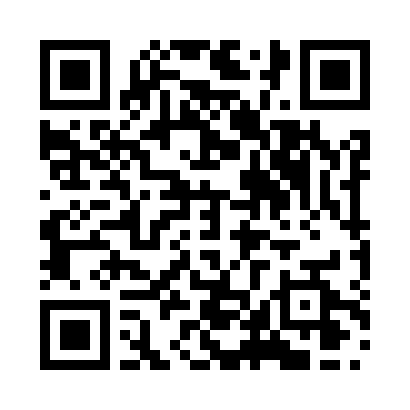

In [27]:
# create qr code for url
URL1 = "https://web.aws.riverfog7.com/files/clip_embeddings_tsne.html"
URL2 = "https://web.aws.riverfog7.com/files/clip_embeddings_umap.html"
import qrcode
img1 = qrcode.make(URL1)
img2 = qrcode.make(URL2)
img1

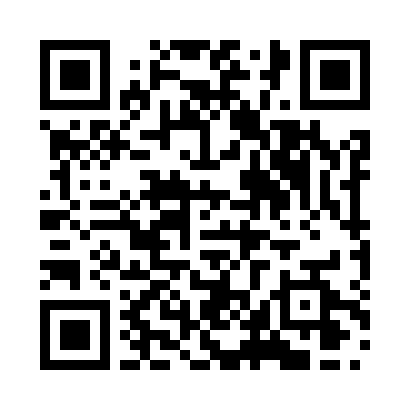

In [28]:
img2